Importing libraries

In [11]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Dropout, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import numpy as np
import os
from sklearn.model_selection import train_test_split
import cv2
import matplotlib.pyplot as plt

Data Loading and Preprocessing

In [12]:
def load_images(image_dir, mask_dir, img_size=(128, 128)):
    images = []
    masks = []
    image_files = sorted(os.listdir(image_dir))
    mask_files = sorted(os.listdir(mask_dir))

    for img_file, mask_file in zip(image_files, mask_files):
        img_path = os.path.join(image_dir, img_file)
        mask_path = os.path.join(mask_dir, mask_file)
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, img_size)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, img_size)
        images.append(img)
        masks.append(mask)
        
    images = np.array(images)
    masks = np.array(masks)
    masks = np.expand_dims(masks, axis=-1)
    images = images / 255.0
    masks = masks / 255.0
    return images, masks

DATA_DIR = 'D:/Notes/Masters/Computer Vision/archive (1)/tiff/' #download the dataset from "https://www.kaggle.com/datasets/balraj98/massachusetts-roads-dataset" and change the path according to it.

images_train_dir = os.path.join(DATA_DIR, 'train')
masks_train_dir = os.path.join(DATA_DIR, 'train_labels')

images_valid_dir = os.path.join(DATA_DIR, 'val')
masks_valid_dir = os.path.join(DATA_DIR, 'val_labels')

images_test_dir = os.path.join(DATA_DIR, 'test')
masks_test_dir = os.path.join(DATA_DIR, 'test_labels')

img_size = (128, 128)
train_images, train_masks = load_images(images_train_dir, masks_train_dir, img_size)
valid_images, valid_masks = load_images(images_valid_dir, masks_valid_dir, img_size)
test_images, test_masks = load_images(images_test_dir, masks_test_dir, img_size)

Define the SegNet Model Architecture

In [13]:
def segnet_model(input_size=(128, 128, 3)):
    inputs = Input(shape=input_size)
    
    # Encoder
    x = Conv2D(64, (3, 3), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)

    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)

    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)

    x = Conv2D(512, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)

    x = Conv2D(512, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)
    
    # Decoder
    x = UpSampling2D()(x)
    x = Conv2D(512, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = UpSampling2D()(x)
    x = Conv2D(512, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = UpSampling2D()(x)
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = UpSampling2D()(x)
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = UpSampling2D()(x)
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(x)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

model = segnet_model(input_size=(128, 128, 3))
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_25 (Activation)      │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_26 (Activation)      │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_27 (Activation)      │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_28 (Activation)      │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_29          │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_29 (Activation)      │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_30          │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_30 (Activation)      │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 32, 32, 256)    │       590,08

 Total params: 29,458,945 (112.38 MB)

 Trainable params: 29,443,073 (112.32 MB)

 Non-trainable params: 15,872 (62.00 KB)

Training the Model

In [14]:
callbacks = [
    ModelCheckpoint('road_segmentation_model.keras', save_best_only=True, monitor='val_loss', mode='min'),
    EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min')
]

history = model.fit(
    train_images, train_masks,
    validation_data=(valid_images, valid_masks),
    epochs=10,
    batch_size=16,
    callbacks=callbacks
)

Epoch 1/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 368s 5s/step - accuracy: 0.8040 - loss: 0.4424 - val_accuracy: 0.8753 - val_loss: 0.4223
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 338s 5s/step - accuracy: 0.9430 - loss: 0.1916 - val_accuracy: 0.9177 - val_loss: 0.2665
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 345s 5s/step - accuracy: 0.9439 - loss: 0.1855 - val_accuracy: 0.9177 - val_loss: 0.2616
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 352s 5s/step - accuracy: 0.9432 - loss: 0.1872 - val_accuracy: 0.9177 - val_loss: 0.2564
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 359s 5s/step - accuracy: 0.9468 - loss: 0.1789 - val_accuracy: 0.9177 - val_loss: 0.3026
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 299s 4s/step - accuracy: 0.9432 - loss: 0.1853 - val_accuracy: 0.9177 - val_loss: 0.2971
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 296s 4s/step - accuracy: 0.9449 - loss: 0.1822 - val_accuracy: 0.9177 - val_loss: 0.2787
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 298s 4s/step - accuracy: 0.9448 - loss: 0.1810 - val_accuracy: 0.9177 - v

Display the predictions

In [15]:
def display_predictions(images, masks, predictions, num=5):
    plt.figure(figsize=(15, num * 5))
    for i in range(num):
        plt.subplot(num, 3, 3 * i + 1)
        plt.imshow(images[i])
        plt.title('Original Image')
        plt.axis('off')
        
        plt.subplot(num, 3, 3 * i + 2)
        plt.imshow(masks[i].squeeze(), cmap='gray')
        plt.title('Ground Truth Mask')
        plt.axis('off')
        
        plt.subplot(num, 3, 3 * i + 3)
        plt.imshow(predictions[i].squeeze(), cmap='gray')
        plt.title('Predicted Mask')
        plt.axis('off')
    plt.show()

Evaluating the Model

In [16]:
loss, accuracy = model.evaluate(valid_images, valid_masks)
print(f"Validation Loss: {loss}")
print(f"Validation Accuracy: {accuracy}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 821ms/step - accuracy: 0.9177 - loss: 0.2512
Validation Loss: 0.251247376203537
Validation Accuracy: 0.9176984429359436


Making Predictions

In [17]:
valid_predictions = model.predict(valid_images)

# Convert predictions to binary masks
valid_predicted_masks = (valid_predictions > 0.5).astype(np.uint8)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


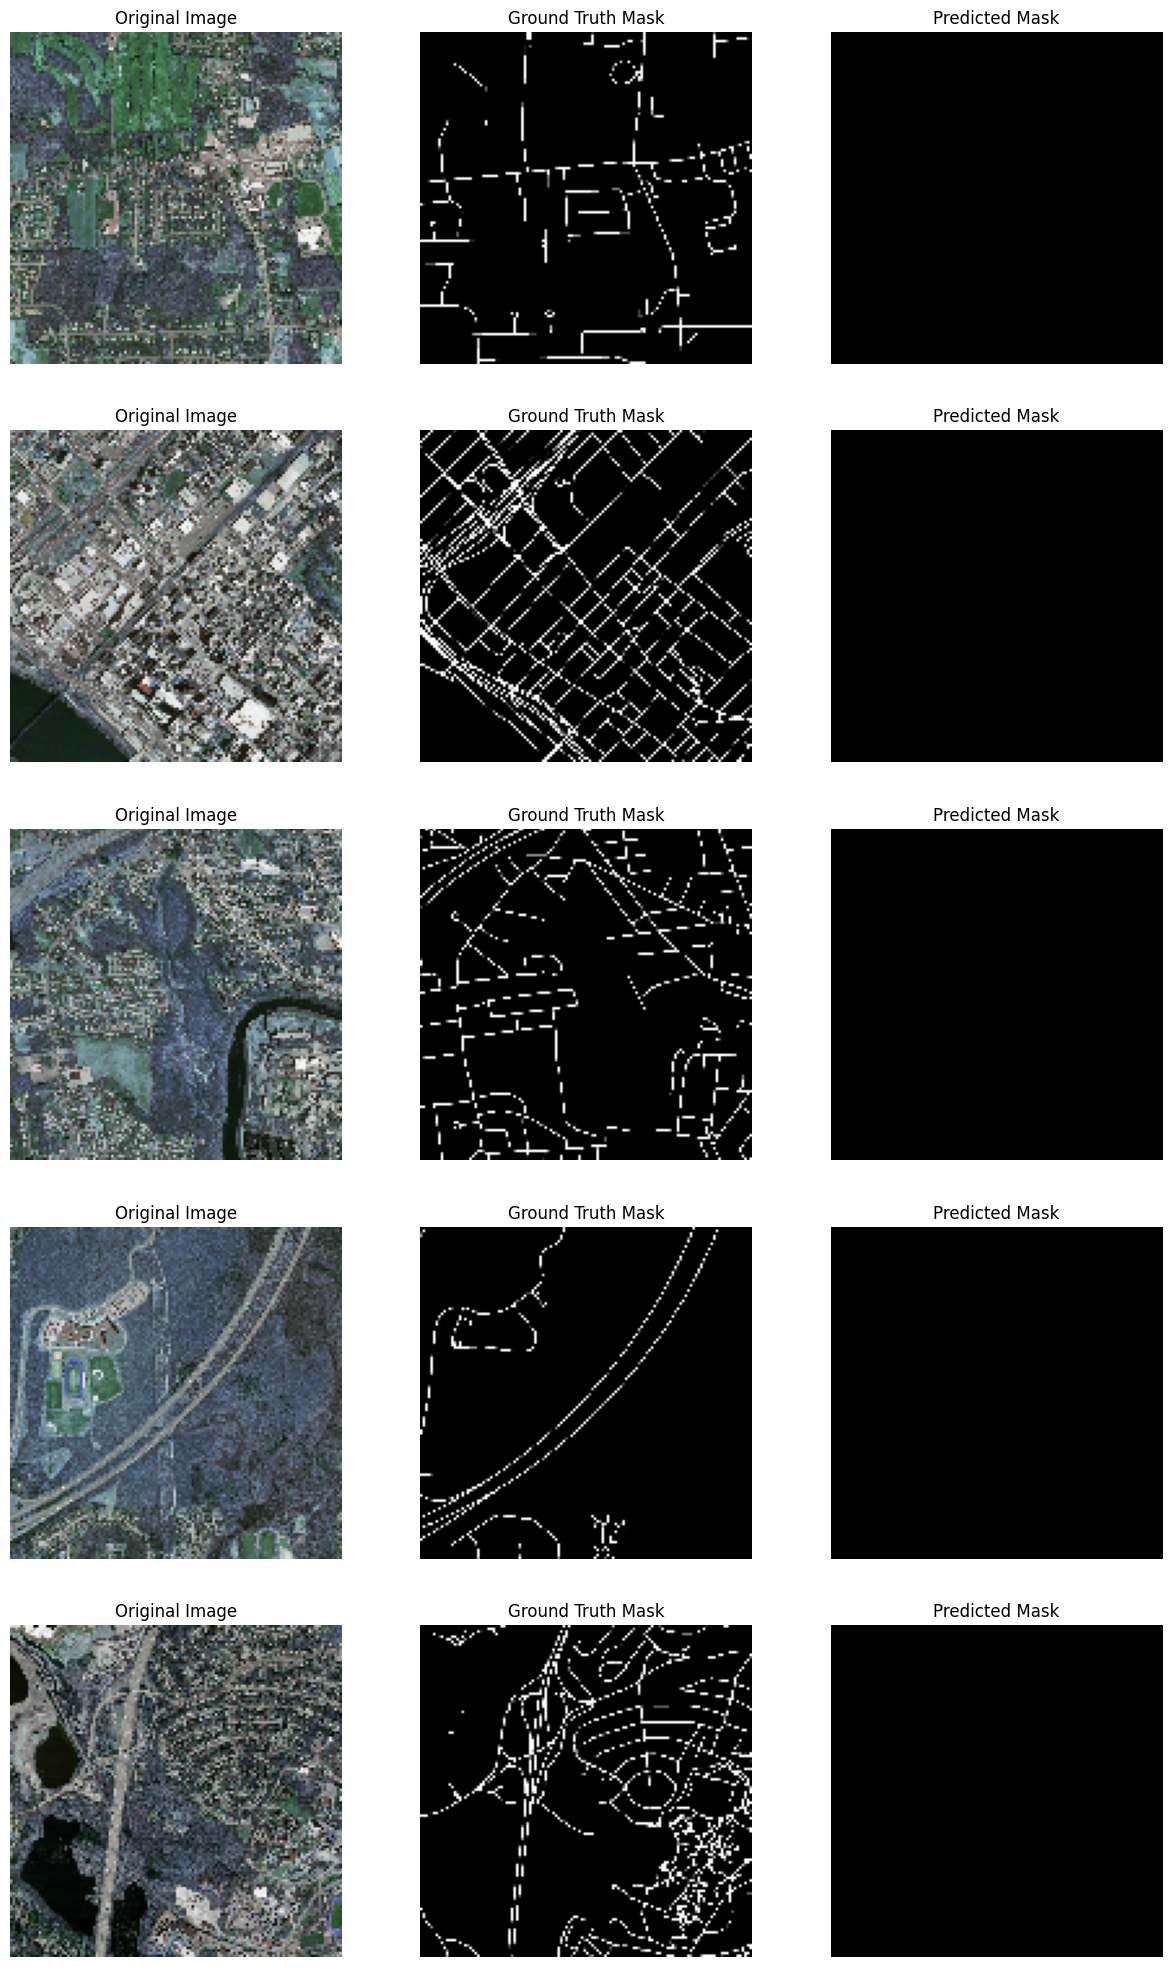

In [18]:
# Display validating images, their true masks, and the predicted masks
display_predictions(valid_images, valid_masks, valid_predicted_masks)

Testing the model

In [19]:
loss, accuracy = model.evaluate(test_images, test_masks)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.9455 - loss: 0.1834
Test Loss: 0.1864185780286789
Test Accuracy: 0.944132924079895


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 940ms/step


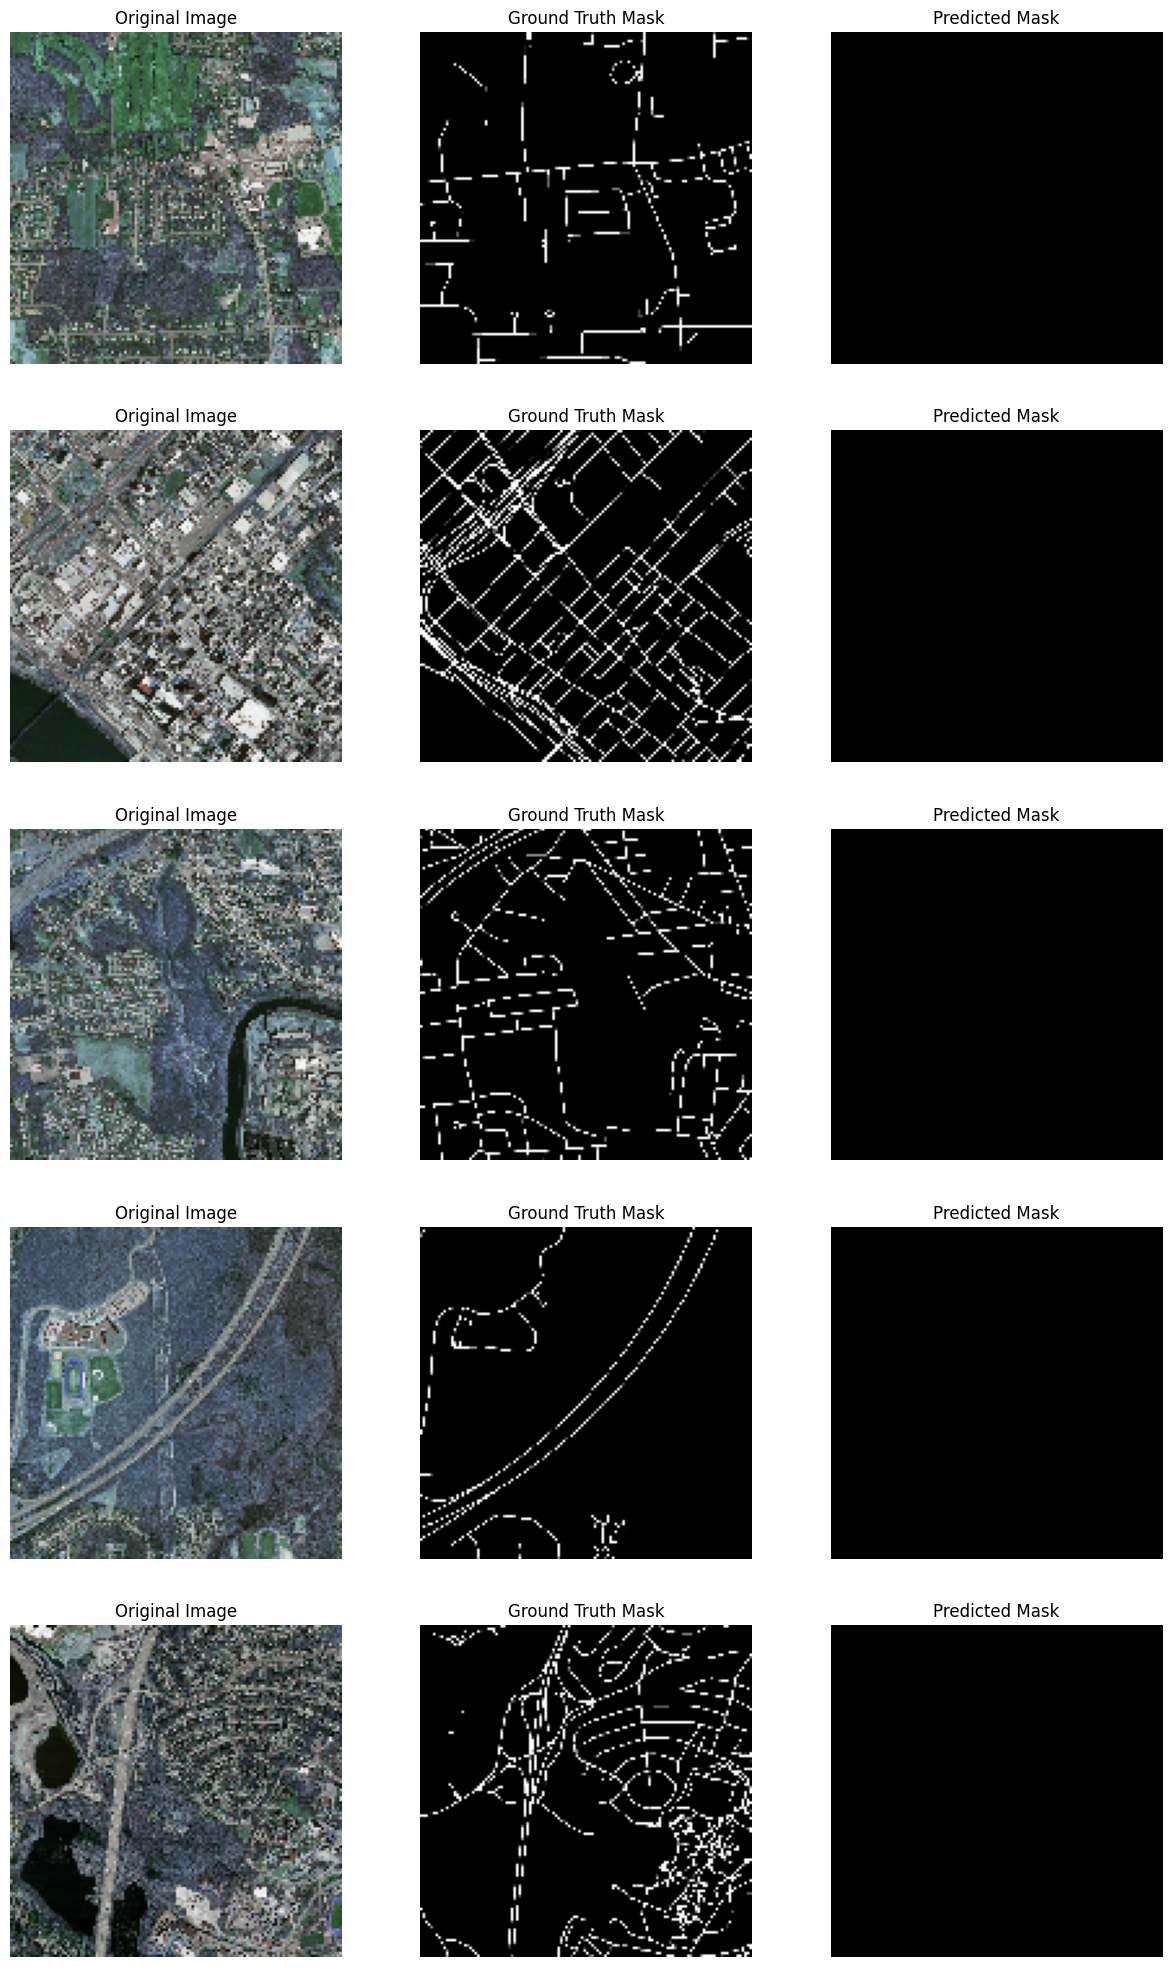

In [20]:
test_predictions = model.predict(test_images)

# Convert predictions to binary masks
test_predicted_masks = (test_predictions > 0.5).astype(np.uint8)

# Display validating images, their true masks, and the predicted masks
display_predictions(valid_images, valid_masks, valid_predicted_masks)